O seguinte projeto tem como objetivo fazer uma análise de risco de crédito, que consiste na possibilidade de perdas financeiras devido a inadimplência por parte do tomador do crédito.

Para realizar o projeto utilizamos um Dataset com aplicações para crédito onde cada linha representa diversas características da aplicação, desde informações bancárias até o formato de acesso da aplicação, entre elas, uma coluna que classifica se a operação foi considerada inadimplência ou não.

Bibliotecas:

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report

Dataset:

In [69]:
cred = pd.read_csv('acquisition_train.csv')
cred_backup = cred.copy()
cred.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


Limpeza dos dados e Análise exploratória:

In [70]:
# Excluindo linhas duplicadas caso existam:

cred.drop_duplicates()

# Informações básicas sobre o dataset:

cred.info()

# O dataset contem 43 colunas com 45 mil linhas com os seguintes tipos  
# de dados e números de valores não nulos.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

In [71]:
# Porcentagem de dados faltantes:

dados_faltantes = (cred.isnull().sum()/cred.shape[0]*100)
print(dados_faltantes[dados_faltantes>0].sort_values(ascending=False))

# Verificamos colunas com mais de 50% de dados faltantes.

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

In [72]:
# Criando um novo dataset contendo as colunas com menos de 50% de dados faltantes:

index = dados_faltantes[dados_faltantes<50.0].index

dados = cred[index]

# Verificando informações sobre as variáveis numéricas:

dados.describe()

# [reported_income] apresenta valores "inf" e 
# [external_data_provider_email_seen_before] apresenta valor mínimo inconsistente

,score_3,score_4,score_5,score_6,risk_rate,credit_limit,income,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income,shipping_zip_code
count,44438.000000,45000.000000,45000.000000,45000.000000,44438.000000,31200.000000,4.443800e+04,44303.000000,44426.000000,44438.000000,33456.000000,45000.000000,45000.000000,29876.000000,42767.000000,45000.000000,45000.00,45000.000000
mean,347.983258,100.006797,0.500037,99.925228,0.296717,34381.951154,7.160739e+04,0.076270,0.004569,10.696701,11.068119,247.537000,1.501067,0.503381,12.534781,500.399800,inf,33923.514844
std,110.429165,3.178080,0.288326,10.016549,0.101933,36586.982218,5.185897e+04,0.274052,0.079400,4.592463,4.595501,146.118398,1.114941,0.499997,126.530487,287.968873,NaN,12692.406382
min,0.000000,86.191572,0.000035,60.663039,0.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.00,12001.000000
25%,270.000000,97.867036,0.252150,93.198353,0.220000,10000.000000,4.501078e+04,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50948.25,22937.000000
50%,340.000000,100.018900,0.500753,99.974796,0.290000,25647.000000,6.126676e+04,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,503.000000,101779.00,33896.000000
75%,420.000000,102.141797,0.748816,106.640275,0.360000,47086.750000,8.601923e+04,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151337.25,44910.000000
max,990.000000,113.978234,0.999973,142.192400,0.900000,448269.000000,5.000028e+06,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf,56000.000000


In [73]:
# Contornando as inconsistências na coluna [reported_income]:

# Removendo as linhas com [reported_income] igual a inf:
dados = dados[dados['reported_income'] != np.inf]

# Contornando as inconsistências na coluna [external_data_provider_email_seen_before]:

# Substituindo valores negativos de [external_data_provider_email_seen_before] por valores nulos:
dados.loc[dados['external_data_provider_email_seen_before']<0] = np.nan

In [74]:
# A variável alvo é representada pela coluna [target default]

a = dados['target_default'].isnull().sum()
print(f'Número de dados faltantes na variável alvo: {a}')

# Excluindo linhas faltantes na variável alvo:

dados.dropna(subset=['target_default'], inplace=True)

Número de dados faltantes na variável alvo: 4445


In [75]:
# Obtendo os índices referentes as colunas com variáveis numéricas e categóricas:

dados_n = dados.select_dtypes(exclude='object')
indx_num = dados_n.columns

dados_c = dados.select_dtypes('object')
indx_cat = dados_c.columns

# Número de variáveis (incluindo variável alvo): 

print(f'Número de variáveis numéricas: {dados[indx_num].shape[1]}')
print(f'Número de variáveis categóricas: {dados[indx_cat].shape[1]}')

Número de variáveis numéricas: 18
Número de variáveis categóricas: 20


In [76]:
# Número de valores únicos para variáveis categóricas (cardinalidade):

print(dados[indx_cat].nunique())

ids                                  40488
target_default                           2
score_1                                  7
score_2                                 35
reason                               13881
facebook_profile                         2
state                                   50
zip                                    821
channel                                  1
job_name                             29711
real_state                               5
application_time_applied             32763
email                                    6
external_data_provider_first_name    30497
lat_lon                              21253
marketing_channel                        9
profile_phone_number                 40488
shipping_state                          25
profile_tags                         23808
user_agent                             297
dtype: int64


In [77]:
# Obtendo uma lista com variáveis de cardinalidade maior que 500:

list = []

for i in indx_cat:
    if dados[i].nunique() > 500:
        list.append(i)

print(list)

# Desta lista com variáveis com alta cardinalidade temos ['application_time_applied'] que contém 
# informações sobre os horários de aplicações que podem conter informações sobre possíveis inadimplentes
# logo vamos removela da lista de variáveis a serem excluídas

list.remove('application_time_applied')

['ids', 'reason', 'zip', 'job_name', 'application_time_applied', 'external_data_provider_first_name', 'lat_lon', 'profile_phone_number', 'profile_tags']


In [78]:
# Removendo colunas utilizando a lista anterior:

dados.drop(labels=list, axis=1, inplace=True)

In [79]:
# Tratando dados categóricos:

# Limpando alguns dados categóricos:

dados['email'].replace('hotmaill.com', 'hotmail.com', inplace=True)
dados['email'].replace('gmaill.com', 'gmail.com', inplace=True)

dados['facebook_profile'].replace(np.nan, False, inplace=True)
dados['facebook_profile'] = dados['facebook_profile'].map({True:1, False:0})

dados['shipping_state'] = dados['shipping_state'].str[-2:]

In [80]:
# Escrevendo uma função para substituir os valores faltantes de uma coluna por valores
# presentes na coluna na mesma proporção de ocorrência

def preencher_proporção(col):
    """ Preenche valores ausentes na mesma proporção dos valores presentes

    Recebe uma coluna e retorna a coluna com os valores faltantes preenchidos
    na proporção dos valores existentes."""

    # gerando o dicionário com valores únicos e sua porcentagem:
    por = col.value_counts(normalize=True).to_dict()

    # transformando as chaves e valores do dicionário em uma lista:
    percent = [por[key] for key in por]
    lab = [key for key in por]

    # utilizando as listas para preencher os valores nulos na proporção correta:
    s = pd.Series(np.random.choice(lab, p=percent, size=col.isnull().sum()))
    col = col.fillna(s)

    # verificando se todos os valores ausentes foram preenchidos e
    # preenchendo os que não tiverem sido:
    if len(col.isnull()) > 0:
        col.fillna(value=max(por, key=por.get), inplace=True, axis=0)
    
    return col

In [81]:
# Iterando as colunas do dataframe aplicando a função acima em variáveis categóricas e
# substiuindo valores numéricos faltantes pela mediana:

for col in dados.iloc[:,1:].columns.tolist():
    if dados[col].dtypes == 'O':
        dados[col] = preencher_proporção(dados[col])
    else:
        dados[col].fillna(value=dados[col].median(), inplace=True, axis=0)

dados.isnull().sum()

target_default                                     0
score_1                                            0
score_2                                            0
score_3                                            0
score_4                                            0
score_5                                            0
score_6                                            0
risk_rate                                          0
credit_limit                                       0
income                                             0
facebook_profile                                   0
state                                              0
channel                                            0
real_state                                         0
n_bankruptcies                                     0
n_defaulted_loans                                  0
n_accounts                                         0
n_issues                                           0
application_time_applied                      

Análise Explanatória e Feature Engineering:

Text(0.5, 1.0, 'Índice de inadimplência por Estado')

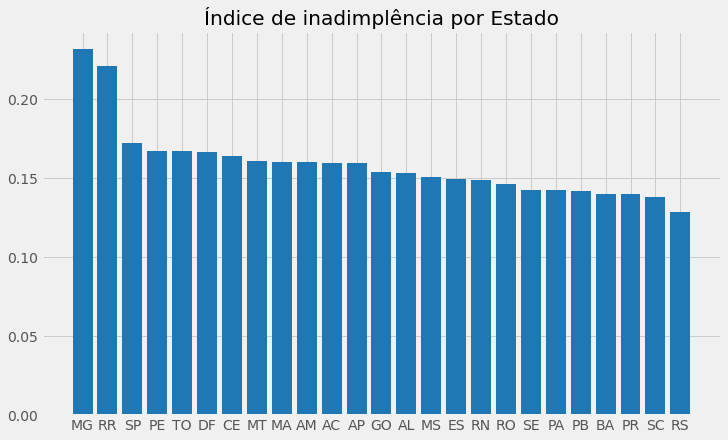

In [82]:
# A seguir vamos visualizar a relação entre algumas variáveis com a variável alvo:

g1 = dados.groupby('shipping_state')['target_default'].mean().sort_values(ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,6], layout='constrained')
plt.bar(g1.index, g1, width=0.8, linewidth=0.9, color='tab:blue')
plt.title('Índice de inadimplência por Estado')


# Com a figura a seguir podemos observar o impacto de cada Estado na inadimplência.
# Sendo os Estados do Minas Gerais e Roraima com maior índice de inadimplência.


Text(0.5, 1.0, 'Índice de inadimplência por horário de aplicação')

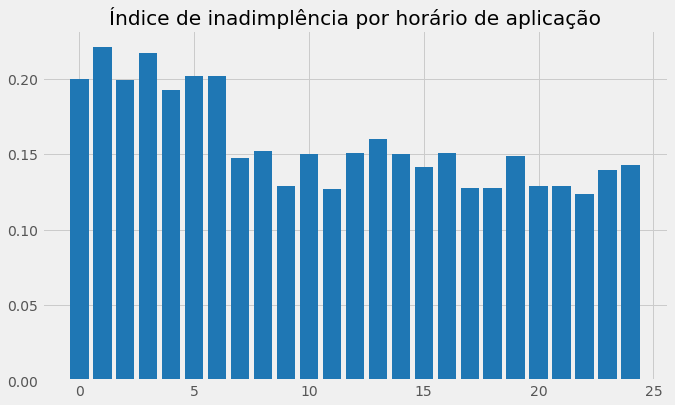

In [83]:
# Uma variável interessante de se observar é o horário de aplicação:

# Excluindo minutos e segundos na variável [application_time_applied]

dados['application_time_applied'] = dados['application_time_applied'].str[:2].astype(int)

g2 = dados.groupby('application_time_applied')['target_default'].mean().sort_values(ascending=False)

plt.style.use('fivethirtyeight')
plt.figure(figsize=[10,6])
plt.bar(g2.index, g2, color='tab:blue')
plt.title('Índice de inadimplência por horário de aplicação')

# Podemos notar pelo gráfico abaixo um maior índice de inadimplência para aplicações 
# realizadas entre 0 e 6 horas

In [84]:
# Uma maneira de aproveitar esta informação é criando uma nova coluna com valor igual a 1
# referente ao intervalo de tempo com maior índice de inadimplência e 0 para demais horários

dados['madrugada'] = dados['application_time_applied'].apply(lambda x: 1 if x<=6 else 0)

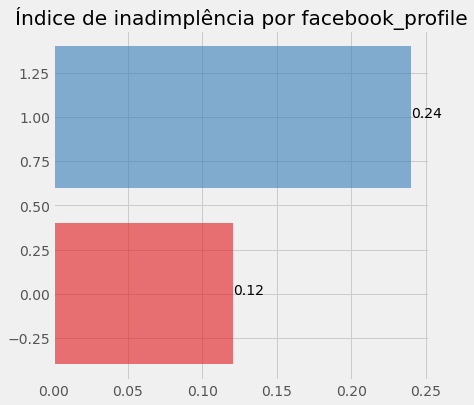

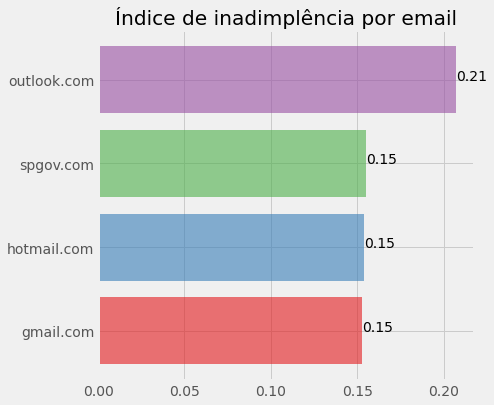

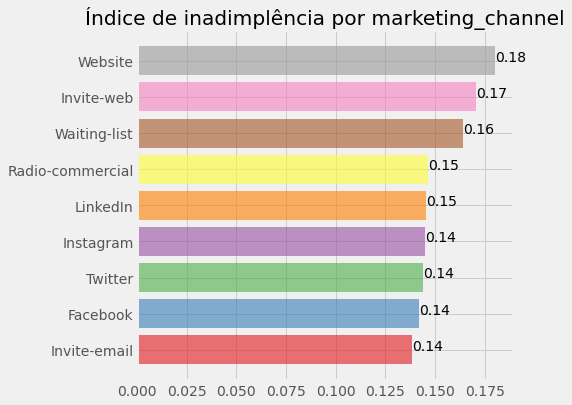

In [85]:
# Visualizando a relação de outras variáveis categóricas com a variável alvo:

cat = ['facebook_profile', 'email', 'marketing_channel']

for i in cat:
    gi = dados.groupby(i)['target_default'].mean().sort_values(ascending=True)

    plt.style.use('fivethirtyeight')
    plt.figure(figsize=[6,6])
    plt.barh(gi.index, gi, color=sns.color_palette('Set1'), alpha=0.6)
    for index, value in enumerate(gi): 
        plt.text(value, index, 
             str(round(value, 2)))
    plt.title(f'Índice de inadimplência por {i}')

In [86]:
# [facebook_profile] - Podemos ver uma maior chance de inadimplência para aplicações
# com perfil no Facebook.

# [mail] - aplicações feitas com @outlook.com tem uma maior probabilidade de inadimplência. 

# [marketing channel] - Índices são relativamente próximos para cada formato de aplicação.

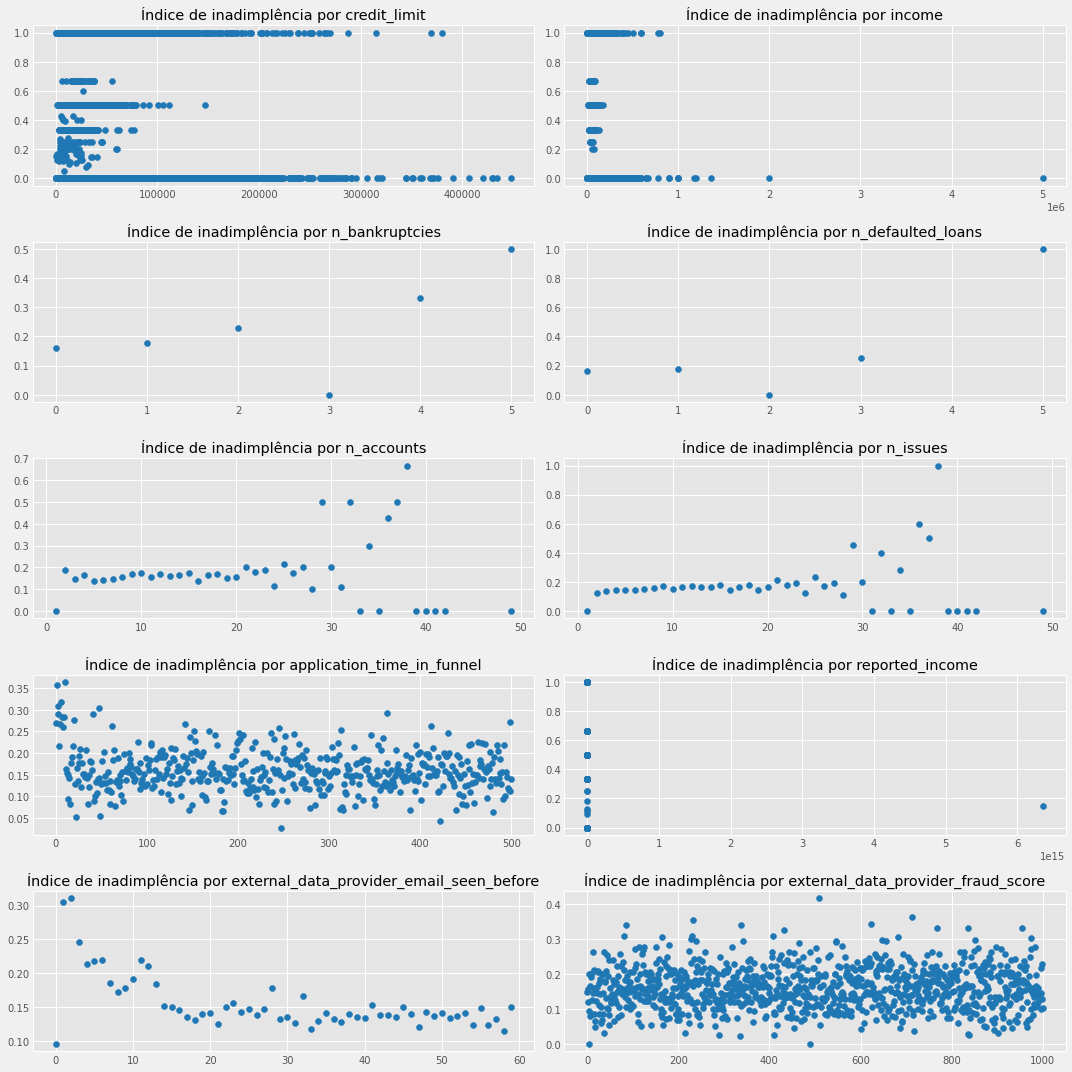

In [87]:
# Visualizando a relação de variáveis numéricas com a variável alvo:

num = ['credit_limit', 'income', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues',
    'application_time_in_funnel', 'reported_income', 'external_data_provider_email_seen_before',
    'external_data_provider_fraud_score']

fig = plt.figure(figsize=(15, 15))
plt.style.use('ggplot')

for j in range(len(num)):
    gj = dados.groupby(num[j])['target_default'].mean()
    ax = fig.add_subplot(5, 2, j+1)
    ax.scatter(gj.index, gj, color='tab:blue')
    ax.set_title(f'Índice de inadimplência por {num[j]}')

plt.tight_layout()


In [88]:
# Podemos ver uma relação aproximadamente crescente entre a probabilidade de inadimplência 
# com [n_bankruptcies] e [n_defaulted_loans]:

  # [n_bankruptcies] - implicam em uma maior chance de inadimplência para maior número de
  # falências

  # [n_defaulted_loans] - implicam em uma maior chance de inadimplência para maior número de
  # "aplicações padronizadas"

# Relação relativamente constante em um certo intervalo  com uma descontinuidade para valores
#  próximos a 40, onde a probabilidade de inadimplência aparenta ser nula para as variáveis 
# [n_accounts] e [n_issues]

  # [n_accounts] e [n_issues] - implicam em uma baixíssima chance de inadimplência após um 
  # certa quantidade de contas abertas e problemas registrados

# Podemos observar uma relação que decresce exponencialmente para valores maiores que zero
# para a variável [external_data_provider_email_seen_before]


In [89]:
# Utilizando LabelEncoder nas variáveis com textos aleatórios e as transformando em dummies com as demais
# variáveis categóricas para preparar os dados para os modelos:

col_enc = ['score_1', 'score_2', 'state', 'real_state', 'channel']

for k in col_enc:
    LabEnc = LabelEncoder().fit(dados[col])
    dados[col] = LabEnc.transform(dados[col])

dummies = col_enc + ['shipping_state', 'application_time_applied', 'facebook_profile', 'email', 'marketing_channel']
dummies.remove('facebook_profile')

dados = pd.get_dummies(dados, columns=dummies)

Machine Learning:

In [90]:
# Separando o conjunto de dados para treinar os modelos:

X = dados.drop('target_default', axis=1)
y = dados['target_default'].astype(int)

X_train, X_test, y_train, y_teste = train_test_split(X,y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Balanceamento de dados

maioria = dados[dados['target_default'] == 0]
minoria = dados[dados['target_default'] == 1]

minoria_balanceada = resample(minoria, replace=True)
dados_b = pd.concat([maioria, minoria_balanceada])

Xb = dados_b.drop('target_default', axis=1)
yb = dados_b['target_default'].astype(int)

Xb_train, Xb_test, yb_train, yb_teste = train_test_split(Xb,yb)

scaler = StandardScaler()
Xb_train_s = scaler.fit_transform(Xb_train)
Xb_test_s = scaler.fit_transform(Xb_test)

# Os dados foram balanceados com StandarScaler que padroniza os dados para média 0 e 
# desvio padrão igual a 1 para aumentar a eficiência do modelo.

In [91]:
# A seguir vamos utilizar 4 modelos (RandomForest Classifier, Logistic Regression,
# DecisionTree Classifier e XGB Classifier) com os dados normais e balanceados.

# Utilizando cross_validade para obter as métricas da precisão e acurácia do modelo
# referente ao conjunto de dados para treino:

RF = cross_validate(RandomForestClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision'])
RF_b = cross_validate(RandomForestClassifier(), Xb_train_s, yb_train, scoring=['accuracy', 'precision'])

LR = cross_validate(LogisticRegression(), X_train_s, y_train, scoring=['accuracy', 'precision'])
LR_b = cross_validate(LogisticRegression(), Xb_train_s, yb_train, scoring=['accuracy', 'precision'])

DT = cross_validate(DecisionTreeClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision'])
DT_b = cross_validate(DecisionTreeClassifier(), Xb_train_s, yb_train, scoring=['accuracy', 'precision'])

XGB = cross_validate(XGBClassifier(), X_train_s, y_train, scoring=['accuracy', 'precision'])
XGB_b = cross_validate(XGBClassifier(), Xb_train_s, yb_train, scoring=['accuracy', 'precision'])

In [92]:
# Criando um dataset para armazenar os resultados de cada modelo:

resultados = pd.DataFrame({
    'lab': ['accuracy', 'precision'],
    'Random Forest': [RF['test_accuracy'].mean(), RF['test_precision'].mean()],
    'Random Forest (b)': [RF_b['test_accuracy'].mean(), RF_b['test_precision'].mean()],
    'Logistic Regression': [LR['test_accuracy'].mean(), LR['test_precision'].mean()],
    'Logistic Regression (b)': [LR_b['test_accuracy'].mean(), LR_b['test_precision'].mean()],
    'Decision Tree Class.': [DT['test_accuracy'].mean(), DT['test_precision'].mean()],
    'Decision Tree Class. (b)': [DT_b['test_accuracy'].mean(), DT_b['test_precision'].mean()],
    'XGB Classifier': [XGB['test_accuracy'].mean(), XGB['test_precision'].mean()],
    'XGB Classifier (b)': [XGB_b['test_accuracy'].mean(), XGB_b['test_precision'].mean()]
}).set_index('lab')
resultados.index.name=None
resultados = resultados.transpose()

resultados

# Podemos ver no dataset a seguir que de forma geral o resultado foi melhorar para os modelos que
# utilizaram dados balanceados como entrada.

# O modelo Random Forest com dados balanceados teve o melhor desempenho entre os demais modelos,
# logo vamos utiliza-lo para o modelo final que ainda irá passar por um processo de tunning de 
# hiperparâmetros para optmização.

,accuracy,precision
Random Forest,0.838998,0.615763
Random Forest (b),0.911743,0.989398
Logistic Regression,0.840973,0.576350
Logistic Regression (b),0.841862,0.545130
Decision Tree Class.,0.744056,0.237854
Decision Tree Class. (b),0.824047,0.459081
XGB Classifier,0.835177,0.469787
XGB Classifier (b),0.869591,0.739526


Hiperparâmetros:

In [93]:
# Optimizaremos o modelo tunando os seguintes parâmetros:
    # criterion
    # n_estimators
    # max_depth
    # min_samples_split
    # min_samples_leaf

In [94]:
# criterion

kfold = StratifiedKFold(n_splits=5, shuffle=True)

RF = RandomForestClassifier()

parametro = {'criterion': ['gini', 'entropy']}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(Xb_train_s, yb_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

Melhor resultado: 0.835546112769241 para parâmetro: {'criterion': 'entropy'}


In [95]:
# n_estimators

RF = RandomForestClassifier(criterion='entropy')

parametro = {'n_estimators': range(50,500,50)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(Xb_train_s, yb_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')


Melhor resultado: 0.8443381021947367 para parâmetro: {'n_estimators': 400}


In [97]:
# max_depth

RF = RandomForestClassifier(criterion='entropy', n_estimators=400)

parametro = {'max_depth': range(1,10)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(Xb_train_s, yb_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

Melhor resultado: 0.7620742150746895 para parâmetro: {'max_depth': 9}


In [98]:
# min_samples_split

RF = RandomForestClassifier(criterion='entropy', n_estimators=400, max_depth=9)

parametro = {'min_samples_split': range(2,10,2)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(Xb_train_s, yb_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

Melhor resultado: 0.7613719671329395 para parâmetro: {'min_samples_split': 4}


In [99]:
# min_samples_leaf

RF = RandomForestClassifier(criterion='entropy', n_estimators=400, max_depth=9, min_samples_split=4)

parametro = {'min_samples_leaf': range(2,10,2)}

search = GridSearchCV(RF, parametro, scoring='roc_auc', cv=kfold)
resultado = search.fit(Xb_train_s, yb_train)

print(f'Melhor resultado: {resultado.best_score_} para parâmetro: {resultado.best_params_}')

Melhor resultado: 0.7594335103591745 para parâmetro: {'min_samples_leaf': 2}


In [100]:
# Construindo um novo modelo de RandomForest com os parâmetros ajustados:

RF_final = RandomForestClassifier(
           criterion='entropy', 
           n_estimators=400, 
           max_depth=9, 
           min_samples_split=4,
           min_samples_leaf=2)

#Treinando o modelo com os dados de treino

RF_final.fit(Xb_train_s, yb_train)

# Calculando o erro médio absoluto para previsões feitas com os dados de treino
# e teste

mae_treino = mean_absolute_error(yb_train, RF_final.predict(Xb_train_s))
mae_teste = mean_absolute_error(yb_teste, RF_final.predict(Xb_test_s))

print('erro médio absoluto:')
print(f'treino: {mae_treino}')
print(f'teste: {mae_teste}')

# Podemos observar que o modelo treinado obteve baixo erro médio absoluto na
# previsão para os dados de treino e teste

erro médio absoluto:
treino: 0.15971810577619705
teste: 0.16251728907330568


In [101]:
print(classification_report(yb_teste, RF_final.predict(Xb_test_s)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      8477
           1       0.00      0.00      0.00      1645

    accuracy                           0.84     10122
   macro avg       0.42      0.50      0.46     10122
weighted avg       0.70      0.84      0.76     10122



c:\Users\T-Gamer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\T-Gamer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Conclusão:

Neste projeto concluímos um problema para identificar risco de crédito através de um
algorítmo de Machine Learning que identifica possíveis inadimplêntes.

O projeto foi concluído através das etapas de:

    - Importação das bibliotecas e do Dataset contendo informações sobre as aplicações.
    - Limpeza dos dados e Análise exploratória.
    - Análise Explanatória e Feature Engineering.
    - Machine Learning.
    - Tunning de Hiperparâmetros.

Através das etapas obtemos insights sobre como algumas variáveis impactam na probabilidade
de inadimplência e contruímos um algorítmo preditivo com precisão de 84%, concluíndo assim o
objetivo inicial do projeto.
